In [ ]:
# imports:
import numpy as np
from numpy import array
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc 

In [ ]:
from google.colab import files
import io

In [ ]:
uploaded = files.upload()

Saving eth_mix_log_diff_return1611.csv to eth_mix_log_diff_return1611.csv


# With means for NAN in financial values: 

We will use the mean as replacement for any missing values. 

## Preparing DF and Train and Test data set:

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['eth_mix_log_diff_return1611.csv']))
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


,eth_close,btc_close,dog_close,usdt_close,eth_volume,btc_volume,dog_volume,tw_eth_mean_vader,tw_eth_count,rd_eth_mean_vader,rd_eth_count,gt_eth_adjusted,usdt_volume,close_s&p500,close_vix,close_nasdaq
date,,,,,,,,,,,,,,,,
2020-01-31,-0.024835,-0.016805,-0.019032,-0.000803,-8.761729e+08,-2.946303e+09,-7.448619e+06,0.015198,130.0,0.065177,84.0,-0.545455,-3.127873e+09,-0.017864,0.195788,-0.016043
2020-02-01,0.019316,0.004518,0.011628,0.000567,-1.589192e+08,-3.509833e+09,2.211535e+06,-0.013101,-537.0,-0.045926,-91.0,-0.636364,-5.733785e+09,NaN,NaN,NaN
2020-02-02,0.026559,-0.005178,0.018814,-0.000671,2.484728e+09,4.913080e+09,1.282168e+07,0.013942,173.0,-0.076579,45.0,2.181818,5.797555e+09,NaN,NaN,NaN
2020-02-03,0.006592,-0.005456,-0.011410,-0.001631,-1.661550e+09,9.835956e+07,-1.269588e+07,-0.032091,167.0,0.009148,-106.0,0.609756,-7.111358e+08,0.007228,-0.047279,0.013293
2020-02-04,-0.003242,-0.012185,0.025492,0.002831,-6.786835e+08,-1.040913e+09,1.093337e+07,-0.005582,117.0,0.318094,17.0,-0.731707,-2.898776e+09,0.014869,-0.112995,0.020764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,-0.092256,-0.091305,-0.094221,-0.000304,2.501489e+09,7.107536e+09,1.697515e+09,-0.095105,-1635.0,-0.005971,-182.0,4.384615,1.180157e+10,0.003325,-0.022160,-0.000649
2021-06-26,0.008797,0.017188,0.023273,0.001368,-2.136793e+09,-1.645519e+09,-2.892706e+09,0.025388,-915.0,-0.009688,8.0,-2.923077,-6.112977e+09,NaN,NaN,NaN
2021-06-27,0.078638,0.073747,0.077276,-0.000571,-7.520676e+08,-3.073745e+09,-4.819356e+08,-0.052542,-1084.0,0.000690,-281.0,-5.076923,-7.165088e+09,NaN,NaN,NaN


In [ ]:
# Filling missing values with mean value:
columns = ['close_s&p500','close_vix','close_nasdaq']
df1 = df.copy()
df1 = df1.fillna(df.mean())

In [ ]:
df1.describe()

,eth_close,btc_close,dog_close,usdt_close,eth_volume,btc_volume,dog_volume,tw_eth_mean_vader,tw_eth_count,rd_eth_mean_vader,rd_eth_count,gt_eth_adjusted,usdt_volume,close_s&p500,close_vix,close_nasdaq
count,516.000000,516.000000,516.000000,516.000000,5.160000e+02,5.160000e+02,5.160000e+02,516.000000,516.000000,516.000000,516.000000,516.000000,5.160000e+02,516.000000,516.000000,516.000000
mean,0.004767,0.002573,0.009068,-0.000003,2.366344e+07,1.070284e+07,4.086424e+06,-0.000009,16.988372,-0.000136,1.352713,0.066244,4.117007e+07,0.000752,0.000095,0.001253
std,0.058856,0.043944,0.111940,0.004718,6.045298e+09,2.165411e+10,4.292960e+09,0.023721,1270.561380,0.071723,215.038890,7.906189,1.892601e+10,0.015803,0.074710,0.016877
min,-0.550732,-0.464730,-0.515118,-0.052570,-3.022394e+10,-3.050570e+11,-3.799728e+10,-0.095105,-6468.000000,-0.270707,-1253.000000,-36.842105,-9.566314e+10,-0.127652,-0.266228,-0.131492
25%,-0.020265,-0.013953,-0.022799,-0.000750,-2.316805e+09,-4.385983e+09,-3.025735e+07,-0.013044,-377.000000,-0.040509,-59.000000,-1.275974,-6.670556e+09,-0.001590,-0.029311,-0.000966
50%,0.005985,0.002496,0.000000,-0.000008,-2.454842e+06,-1.558302e+08,-2.667508e+06,0.001016,-15.000000,-0.001687,-6.000000,-0.087016,1.899312e+06,0.000752,0.000095,0.001253
75%,0.033272,0.020317,0.020884,0.000862,2.019769e+09,4.775606e+09,1.510489e+07,0.013089,348.250000,0.040609,50.200000,1.167202,6.962274e+09,0.005211,0.012472,0.007166
max,0.230695,0.171821,1.323469,0.053393,4.406639e+10,2.964614e+11,5.149406e+10,0.095100,11244.000000,0.318094,1701.000000,73.385965,1.395697e+11,0.089683,0.480214,0.089347


In [ ]:
# defining train and test data set: 
train_size = int(len(df1)*0.9)
test_size = len(df1) - train_size 

train,test=df1.iloc[0:train_size],df1.iloc[train_size:len(df1)]
print(len(train),len(test))

464 52


## Preparing for Time Series Forecasting

This step changes data so that the value at the current time step will be predicted by using previous n-time steps value 

Source: https://gist.github.com/curiousily/02f6c7448069dce96cd3f74be4795e29

In [ ]:
def create_dataset(X,y,time_steps=1):
  Xs,ys = [],[]
  for i in range(len(X)-time_steps):
    v = X.iloc[i:(i+time_steps)].values 
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [ ]:
time_steps = 5

In [ ]:
X_train,y_train=create_dataset(train,train.eth_close,time_steps)
X_test,y_test=create_dataset(test,test.eth_close,time_steps)

In [ ]:
print(X_train.shape,y_train.shape)

(459, 5, 16) (459,)


In [ ]:
print(X_train[0],y_train[0])

[[-2.48350161e-02 -1.68050487e-02 -1.90324322e-02 -8.03156729e-04
  -8.76172944e+08 -2.94630313e+09 -7.44861900e+06  1.51977965e-02
   1.30000000e+02  6.51772561e-02  8.40000000e+01 -5.45454545e-01
  -3.12787275e+09 -1.78644764e-02  1.95787615e-01 -1.60426530e-02]
 [ 1.93158752e-02  4.51847214e-03  1.16280380e-02  5.67471132e-04
  -1.58919212e+08 -3.50983322e+09  2.21153500e+06 -1.31007739e-02
  -5.37000000e+02 -4.59262588e-02 -9.10000000e+01 -6.36363636e-01
  -5.73378539e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 2.65591815e-02 -5.17791028e-03  1.88144609e-02 -6.71409185e-04
   2.48472821e+09  4.91308045e+09  1.28216850e+07  1.39418143e-02
   1.73000000e+02 -7.65793251e-02  4.50000000e+01  2.18181818e+00
   5.79755523e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 6.59228985e-03 -5.45597008e-03 -1.14100667e-02 -1.63144330e-03
  -1.66155015e+09  9.83595630e+07 -1.26958840e+07 -3.20906796e-02
   1.67000000e+02  9.14795669e-03 -1.06000000e+02  6.09756098e-01
  -7.11

## Modeling

Sequential LSTM  Keras Model

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 5 16


### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=300,
    batch_size=16,
    validation_split = 0.1,
    verbose=0,
    shuffle=False
)

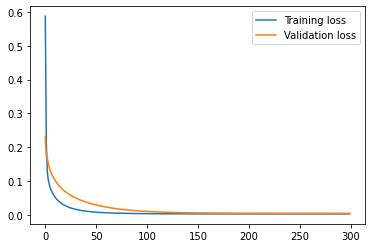

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

## Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)

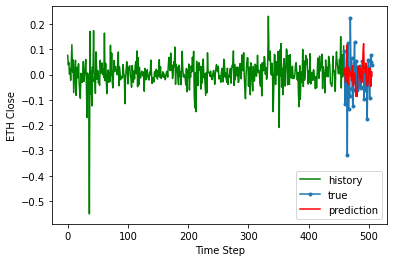

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

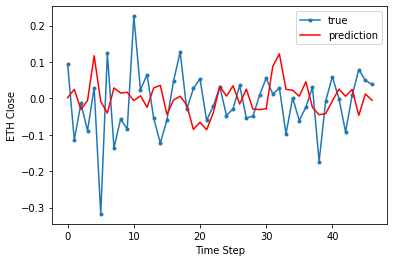

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test, y_pred), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test, y_pred), 5)) 
print("Root mean squared error:",
      round(sm.mean_squared_error(y_test,y_pred)**0.5,5))
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test, y_pred), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test, y_pred), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test, y_pred), 5))

Mean absolute error = 0.07992
Mean squared error = 0.00991
Root mean squared error: 0.09957
Median absolute error = 0.07166
Explain variance score = -0.29063
R2 score = -0.30966


# With -1 as NaN Value: 

## Preparing DF and Train and Test:

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['eth_mix_log_diff_return1611.csv']))
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,eth_close,btc_close,dog_close,usdt_close,eth_volume,btc_volume,dog_volume,tw_eth_mean_vader,tw_eth_count,rd_eth_mean_vader,rd_eth_count,gt_eth_adjusted,usdt_volume,close_s&p500,close_vix,close_nasdaq
date,,,,,,,,,,,,,,,,
2020-01-31,-0.024835,-0.016805,-0.019032,-0.000803,-8.761729e+08,-2.946303e+09,-7448619.0,0.015198,130.0,0.065177,84.0,-0.545455,-3.127873e+09,-0.017864,0.195788,-0.016043
2020-02-01,0.019316,0.004518,0.011628,0.000567,-1.589192e+08,-3.509833e+09,2211535.0,-0.013101,-537.0,-0.045926,-91.0,-0.636364,-5.733785e+09,NaN,NaN,NaN
2020-02-02,0.026559,-0.005178,0.018814,-0.000671,2.484728e+09,4.913080e+09,12821685.0,0.013942,173.0,-0.076579,45.0,2.181818,5.797555e+09,NaN,NaN,NaN
2020-02-03,0.006592,-0.005456,-0.011410,-0.001631,-1.661550e+09,9.835956e+07,-12695884.0,-0.032091,167.0,0.009148,-106.0,0.609756,-7.111358e+08,0.007228,-0.047279,0.013293
2020-02-04,-0.003242,-0.012185,0.025492,0.002831,-6.786835e+08,-1.040913e+09,10933371.0,-0.005582,117.0,0.318094,17.0,-0.731707,-2.898776e+09,0.014869,-0.112995,0.020764


In [ ]:
columns = ['close_s&p500','close_vix','close_nasdaq']
df2 = df.copy()
df2 = df1.fillna(-1)
df2.head()

,eth_close,btc_close,dog_close,usdt_close,eth_volume,btc_volume,dog_volume,tw_eth_mean_vader,tw_eth_count,rd_eth_mean_vader,rd_eth_count,gt_eth_adjusted,usdt_volume,close_s&p500,close_vix,close_nasdaq
date,,,,,,,,,,,,,,,,
2020-01-31,-0.024835,-0.016805,-0.019032,-0.000803,-8.761729e+08,-2.946303e+09,-7448619.0,0.015198,130.0,0.065177,84.0,-0.545455,-3.127873e+09,-0.017864,0.195788,-0.016043
2020-02-01,0.019316,0.004518,0.011628,0.000567,-1.589192e+08,-3.509833e+09,2211535.0,-0.013101,-537.0,-0.045926,-91.0,-0.636364,-5.733785e+09,0.000752,0.000095,0.001253
2020-02-02,0.026559,-0.005178,0.018814,-0.000671,2.484728e+09,4.913080e+09,12821685.0,0.013942,173.0,-0.076579,45.0,2.181818,5.797555e+09,0.000752,0.000095,0.001253
2020-02-03,0.006592,-0.005456,-0.011410,-0.001631,-1.661550e+09,9.835956e+07,-12695884.0,-0.032091,167.0,0.009148,-106.0,0.609756,-7.111358e+08,0.007228,-0.047279,0.013293
2020-02-04,-0.003242,-0.012185,0.025492,0.002831,-6.786835e+08,-1.040913e+09,10933371.0,-0.005582,117.0,0.318094,17.0,-0.731707,-2.898776e+09,0.014869,-0.112995,0.020764


In [ ]:
# defining tran and test: 
train_size = int(len(df2)*0.9)
test_size = len(df2) - train_size 

train,test=df2.iloc[0:train_size],df2.iloc[train_size:len(df2)]
print(len(train),len(test))

464 52


## Preparing for Time Series Forecasting

This step changes data so that the value at the current time step will be predicted by using previous n-time steps value 

Source: https://gist.github.com/curiousily/02f6c7448069dce96cd3f74be4795e29

In [ ]:
def create_dataset(X,y,time_steps=1):
  Xs,ys = [],[]
  for i in range(len(X)-time_steps):
    v = X.iloc[i:(i+time_steps)].values 
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [ ]:
time_steps = 5

In [ ]:
X2_train,y2_train=create_dataset(train,train.eth_close,time_steps)
X2_test,y2_test=create_dataset(test,test.eth_close,time_steps)

In [ ]:
print(X2_train.shape,y2_train.shape)

(459, 5, 16) (459,)


In [ ]:
print(X2_train[0],y2_train[0])

[[-2.48350161e-02 -1.68050487e-02 -1.90324322e-02 -8.03156729e-04
  -8.76172944e+08 -2.94630313e+09 -7.44861900e+06  1.51977965e-02
   1.30000000e+02  6.51772561e-02  8.40000000e+01 -5.45454545e-01
  -3.12787275e+09 -1.78644764e-02  1.95787615e-01 -1.60426530e-02]
 [ 1.93158752e-02  4.51847214e-03  1.16280380e-02  5.67471132e-04
  -1.58919212e+08 -3.50983322e+09  2.21153500e+06 -1.31007739e-02
  -5.37000000e+02 -4.59262588e-02 -9.10000000e+01 -6.36363636e-01
  -5.73378539e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 2.65591815e-02 -5.17791028e-03  1.88144609e-02 -6.71409185e-04
   2.48472821e+09  4.91308045e+09  1.28216850e+07  1.39418143e-02
   1.73000000e+02 -7.65793251e-02  4.50000000e+01  2.18181818e+00
   5.79755523e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 6.59228985e-03 -5.45597008e-03 -1.14100667e-02 -1.63144330e-03
  -1.66155015e+09  9.83595630e+07 -1.26958840e+07 -3.20906796e-02
   1.67000000e+02  9.14795669e-03 -1.06000000e+02  6.09756098e-01
  -7.11

## Modeling

Sequential LSTM  Keras Model

In [ ]:
print('Input shape is:',X2_train.shape[1],X2_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X2_train.shape[1],X2_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 5 16


### Training: 

In [ ]:
history2 = model.fit(
    X2_train,y2_train,
    epochs=300,
    batch_size=16,
    validation_split = 0.1,
    verbose=1,
    shuffle=False
)

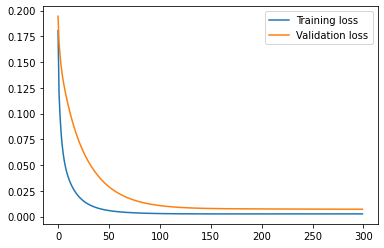

In [ ]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()

## Making Predictions: 

In [ ]:
y2_pred=model.predict(X2_test)

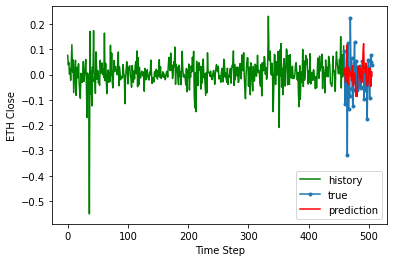

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

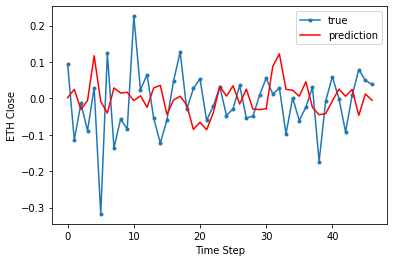

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

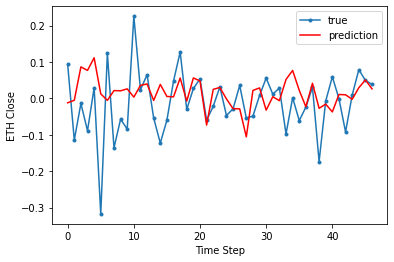

In [ ]:
plt.plot(y2_test, marker='.', label="true")
plt.plot(y2_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Computing prediction accuracy

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y2_test, y2_pred), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y2_test, y2_pred), 5)) 
print("Root mean squared error:",
      round(sm.mean_squared_error(y_test,y_pred)**0.5,5))
print("Median absolute error =", 
      round(sm.median_absolute_error(y2_test, y2_pred), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y2_test, y2_pred), 5)) 
print("R2 score =", 
      round(sm.r2_score(y2_test, y2_pred), 5))

Mean absolute error = 0.06974
Mean squared error = 0.00919
Root mean squared error: 0.09957
Median absolute error = 0.05191
Explain variance score = -0.12862
R2 score = -0.2139


# Tuning and comparing models

With means for NAN in financial values: 

## Preparing DF and Train and Test:

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['eth_mix_log_diff_return1611.csv']))
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
columns = ['close_s&p500','close_vix','close_nasdaq']
df1 = df.copy()
df1 = df1.fillna(df.mean())

In [ ]:
df1.describe()

,eth_close,btc_close,dog_close,usdt_close,eth_volume,btc_volume,dog_volume,tw_eth_mean_vader,tw_eth_count,rd_eth_mean_vader,rd_eth_count,gt_eth_adjusted,usdt_volume,close_s&p500,close_vix,close_nasdaq
count,516.000000,516.000000,516.000000,516.000000,5.160000e+02,5.160000e+02,5.160000e+02,516.000000,516.000000,516.000000,516.000000,516.000000,5.160000e+02,516.000000,516.000000,516.000000
mean,0.004767,0.002573,0.009068,-0.000003,2.366344e+07,1.070284e+07,4.086424e+06,-0.000009,16.988372,-0.000136,1.352713,0.066244,4.117007e+07,0.000752,0.000095,0.001253
std,0.058856,0.043944,0.111940,0.004718,6.045298e+09,2.165411e+10,4.292960e+09,0.023721,1270.561380,0.071723,215.038890,7.906189,1.892601e+10,0.015803,0.074710,0.016877
min,-0.550732,-0.464730,-0.515118,-0.052570,-3.022394e+10,-3.050570e+11,-3.799728e+10,-0.095105,-6468.000000,-0.270707,-1253.000000,-36.842105,-9.566314e+10,-0.127652,-0.266228,-0.131492
25%,-0.020265,-0.013953,-0.022799,-0.000750,-2.316805e+09,-4.385983e+09,-3.025735e+07,-0.013044,-377.000000,-0.040509,-59.000000,-1.275974,-6.670556e+09,-0.001590,-0.029311,-0.000966
50%,0.005985,0.002496,0.000000,-0.000008,-2.454842e+06,-1.558302e+08,-2.667508e+06,0.001016,-15.000000,-0.001687,-6.000000,-0.087016,1.899312e+06,0.000752,0.000095,0.001253
75%,0.033272,0.020317,0.020884,0.000862,2.019769e+09,4.775606e+09,1.510489e+07,0.013089,348.250000,0.040609,50.200000,1.167202,6.962274e+09,0.005211,0.012472,0.007166
max,0.230695,0.171821,1.323469,0.053393,4.406639e+10,2.964614e+11,5.149406e+10,0.095100,11244.000000,0.318094,1701.000000,73.385965,1.395697e+11,0.089683,0.480214,0.089347


In [ ]:
# defining tran and test: 
train_size = int(len(df1)*0.9)
test_size = len(df1) - train_size 

train,test=df1.iloc[0:train_size],df1.iloc[train_size:len(df1)]
print(len(train),len(test))

464 52


## Preparing for Time Series Forecasting

This step changes data so that the value at the current time step will be predicted by using previous n-time steps value 

Source: https://gist.github.com/curiousily/02f6c7448069dce96cd3f74be4795e29

In [ ]:
def create_dataset(X,y,time_steps=1):
  Xs,ys = [],[]
  for i in range(len(X)-time_steps):
    v = X.iloc[i:(i+time_steps)].values 
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [ ]:
time_steps = 20

In [ ]:
X_train,y_train=create_dataset(train,train.btc_close,time_steps)
X_test,y_test=create_dataset(test,test.btc_close,time_steps)

In [ ]:
print(X_train.shape,y_train.shape)

(444, 20, 16) (444,)


In [ ]:
print(X_train[0],y_train[0])

[[-2.48350161e-02 -1.68050487e-02 -1.90324322e-02 -8.03156729e-04
  -8.76172944e+08 -2.94630313e+09 -7.44861900e+06  1.51977965e-02
   1.30000000e+02  6.51772561e-02  8.40000000e+01 -5.45454545e-01
  -3.12787275e+09 -1.78644764e-02  1.95787615e-01 -1.60426530e-02]
 [ 1.93158752e-02  4.51847214e-03  1.16280380e-02  5.67471132e-04
  -1.58919212e+08 -3.50983322e+09  2.21153500e+06 -1.31007739e-02
  -5.37000000e+02 -4.59262588e-02 -9.10000000e+01 -6.36363636e-01
  -5.73378539e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 2.65591815e-02 -5.17791028e-03  1.88144609e-02 -6.71409185e-04
   2.48472821e+09  4.91308045e+09  1.28216850e+07  1.39418143e-02
   1.73000000e+02 -7.65793251e-02  4.50000000e+01  2.18181818e+00
   5.79755523e+09  7.52099920e-04  9.45036158e-05  1.25337426e-03]
 [ 6.59228985e-03 -5.45597008e-03 -1.14100667e-02 -1.63144330e-03
  -1.66155015e+09  9.83595630e+07 -1.26958840e+07 -3.20906796e-02
   1.67000000e+02  9.14795669e-03 -1.06000000e+02  6.09756098e-01
  -7.11

## Modeling

Sequential LSTM  Keras Model

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 20 16


#### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=300,
    batch_size=16,
    validation_split = 0.1,
    verbose=1,
    shuffle=False
)

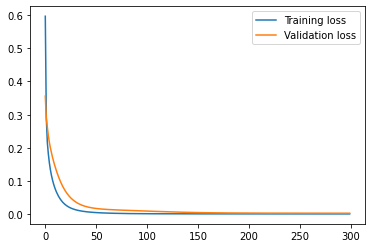

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)

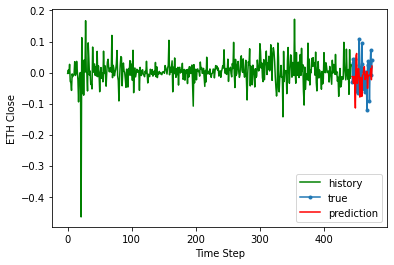

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

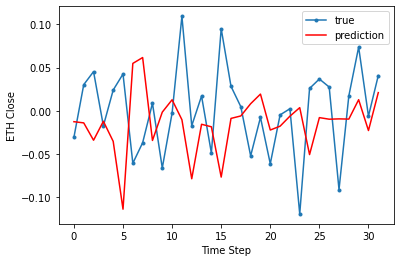

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test, y_pred), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test, y_pred), 5)) 
print("Root mean squared error:",
      round(sm.mean_squared_error(y_test,y_pred)**0.5,5))
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test, y_pred), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test, y_pred), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test, y_pred), 5))

Mean absolute error = 0.05628
Mean squared error = 0.00499
Root mean squared error: 0.07064
Median absolute error = 0.0437
Explain variance score = -0.90962
R2 score = -0.98543


## Modeling 2

Sequential LSTM  Keras Model: different time_steps

In [ ]:
time_steps = 32
X_train,y_train=create_dataset(train,train.btc_close,time_steps)
X_test,y_test=create_dataset(test,test.btc_close,time_steps)

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 32 16


#### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=300,
    batch_size=16,
    validation_split = 0.1,
    verbose=0,
    shuffle=False
)

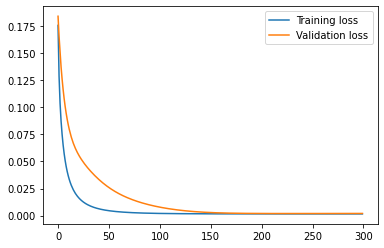

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)

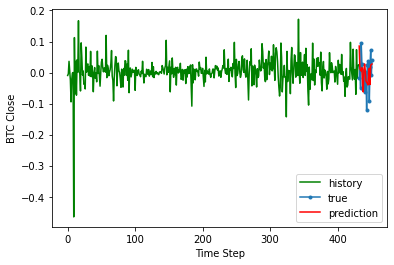

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('BTC Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

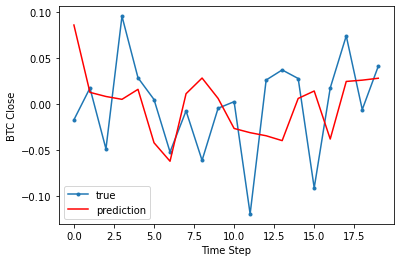

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('BTC Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test, y_pred), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test, y_pred), 5)) 
print("Root mean squared error:",
      round(sm.mean_squared_error(y_test,y_pred)**0.5,5))
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test, y_pred), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test, y_pred), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test, y_pred), 5))

Mean absolute error = 0.0487
Mean squared error = 0.00347
Root mean squared error: 0.05886
Median absolute error = 0.0482
Explain variance score = -0.32692
R2 score = -0.328


## Modeling 3

Sequential LSTM  Keras Model: different time_steps

In [ ]:
time_steps = 1
X_train,y_train=create_dataset(train,train.eth_close,time_steps)
X_test,y_test=create_dataset(test,test.eth_close,time_steps)

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 1 16


#### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=300,
    batch_size=16,
    validation_split = 0.1,
    verbose=0,
    shuffle=False
)

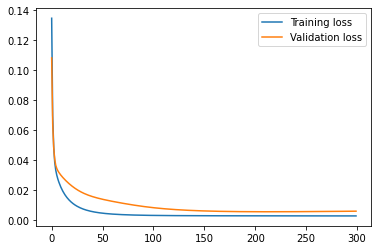

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)

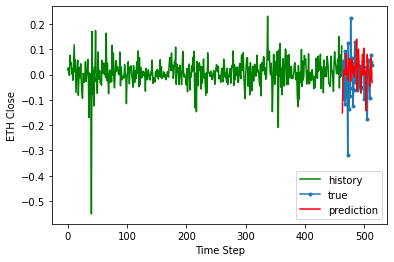

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

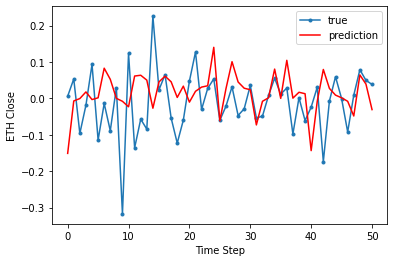

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test, y_pred), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test, y_pred), 5)) 
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test, y_pred), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test, y_pred), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test, y_pred), 5))

Mean absolute error = 0.07911
Mean squared error = 0.01074
Median absolute error = 0.06913
Explain variance score = -0.38674
R2 score = -0.48981


## Modeling 4

Sequential LSTM  Keras Model:
MinMaxScaler

In [ ]:
# defining tran and test: 
train_size = int(len(df1)*0.9)
test_size = len(df1) - train_size 

train,test=df1.iloc[0:train_size],df1.iloc[train_size:len(df1)]
print(len(train),len(test))

464 52


In [ ]:
# Nomralization: 
# fit_transform() for training, transform() for test to avoid data leakage 

y_train,y_test = df1.eth_close.iloc[0:train_size],df1.eth_close.iloc[train_size:len(df1)]

y_train,y_test = y_train.values.reshape(-1, 1),y_test.values.reshape(-1, 1)


from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

train = x_scaler.fit_transform(train)
y_train = y_scaler.fit_transform(y_train)

test =  x_scaler.transform(test)
y_test = y_scaler.transform(y_test)

print('x:',train.shape,test.shape)
print('y:', y_train.shape,y_test.shape)

x: (464, 16) (52, 16)
y: (464, 1) (52, 1)


In [ ]:
def split_sequences(x,y,n_steps):
  X,Y = list(),list()
  for i in range(len(x)):
    end_ix = i+n_steps
    if end_ix >= len(x): 
      break
    else: 
        #seq_x, seq_y = x[i:end_ix, :-1,:], y[i+n_steps]
        seq_x, seq_y = x[i : end_ix], y[i+n_steps]
        X.append(seq_x)
        Y.append(seq_y)
  return array(X),array(Y)

In [ ]:
n_steps = 10
X_train,y_train=split_sequences(train,y_train,n_steps)
X_test,y_test=split_sequences(test,y_test,n_steps)

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2]),
    return_sequences=True
))
model.add(keras.layers.LSTM(
    units = 64,
    return_sequences=True
))
model.add(keras.layers.LSTM(
    units = 32
))
model.add(keras.layers.Dense(units=1))

model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 10 16


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10, 128)           74240     
                                                                 
 lstm_6 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 136,097
Trainable params: 136,097
Non-trainable params: 0
_________________________________________________________________


#### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=50,
    batch_size=16,
    validation_split = 0.1,
    verbose=0,
    shuffle=False
)

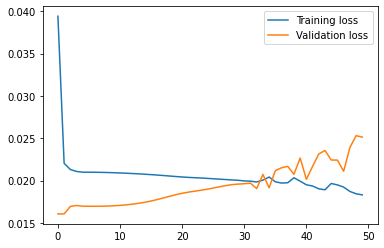

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
y_pred_test_rev = y_scaler.inverse_transform(y_pred)
y_pred_train_rev = y_scaler.inverse_transform(y_pred_train)
y_train_rev = y_scaler.inverse_transform(y_train)
y_test_rev = y_scaler.inverse_transform(y_test)

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test_rev, y_pred_test_rev), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test_rev, y_pred_test_rev), 5)) 
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test_rev, y_pred_test_rev), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test_rev, y_pred_test_rev), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test_rev, y_pred_test_rev), 5))

Mean absolute error = 0.06254
Mean squared error = 0.00845
Median absolute error = 0.0486
Explain variance score = 0.03579
R2 score = -0.08755


In [ ]:
trainScore = sm.mean_squared_error(y_train_rev, y_pred_train_rev) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sm.mean_squared_error(y_test_rev, y_pred_test_rev) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.09 RMSE


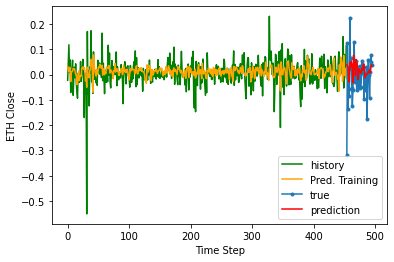

In [ ]:
plt.plot(np.arange(0, len(y_train_rev)), y_train_rev, 'g', label="history")
plt.plot(np.arange(0, len(y_pred_train_rev)), y_pred_train_rev, 'orange', label="Pred. Training")
plt.plot(np.arange(len(y_train_rev), len(y_train_rev) + len(y_test_rev)), y_test_rev, marker='.', label="true")
plt.plot(np.arange(len(y_train_rev), len(y_train_rev) + len(y_test_rev)), y_pred_test_rev, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

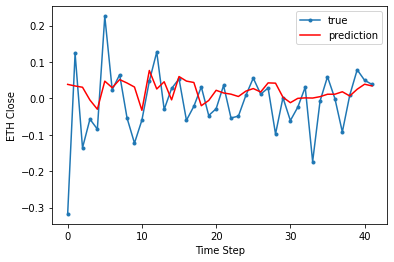

In [ ]:
plt.plot(y_test_rev, marker='.', label="true")
plt.plot(y_pred_test_rev, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Modeling 5

Sequential LSTM  Keras Model:
StandardScaler

In [ ]:
# defining tran and test: 
train_size = int(len(df1)*0.9)
test_size = len(df1) - train_size 

train,test=df1.iloc[0:train_size],df1.iloc[train_size:len(df1)]
print(len(train),len(test))

464 52


In [ ]:
# Nomralization: 
# fit_transform() for training, transform() for test to avoid data leakage 

y_train,y_test = df1.eth_close.iloc[0:train_size],df1.eth_close.iloc[train_size:len(df1)]

y_train,y_test = y_train.values.reshape(-1, 1),y_test.values.reshape(-1, 1)


from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

train = x_scaler.fit_transform(train)
y_train = y_scaler.fit_transform(y_train)

test =  x_scaler.transform(test)
y_test = y_scaler.transform(y_test)

print('x:',train.shape,test.shape)
print('y:', y_train.shape,y_test.shape)

x: (464, 16) (52, 16)
y: (464, 1) (52, 1)


In [ ]:
def split_sequences(x,y,n_steps):
  X,Y = list(),list()
  for i in range(len(x)):
    end_ix = i+n_steps
    if end_ix >= len(x): 
      break
    else: 
        #seq_x, seq_y = x[i:end_ix, :-1,:], y[i+n_steps]
        seq_x, seq_y = x[i : end_ix], y[i+n_steps]
        X.append(seq_x)
        Y.append(seq_y)
  return array(X),array(Y)

In [ ]:
n_steps = 10
X_train,y_train=split_sequences(train,y_train,n_steps)
X_test,y_test=split_sequences(test,y_test,n_steps)

In [ ]:
print('Input shape is:',X_train.shape[1],X_train.shape[2])

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units = 128,
    input_shape=(X_train.shape[1],X_train.shape[2]),
    return_sequences=True
))
model.add(keras.layers.LSTM(
    units = 128,
    return_sequences=True
))
model.add(keras.layers.LSTM(
    units = 64
))
model.add(keras.layers.Dense(units=1))

model.compile(
    loss = 'mean_squared_error',
    optimizer = keras.optimizers.Adam(0.001)
)

Input shape is: 10 16


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 128)           74240     
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 255,297
Trainable params: 255,297
Non-trainable params: 0
_________________________________________________________________


#### Training: 

In [ ]:
history = model.fit(
    X_train,y_train,
    epochs=200,
    batch_size=16,
    validation_split = 0.1,
    verbose=0,
    shuffle=False
)

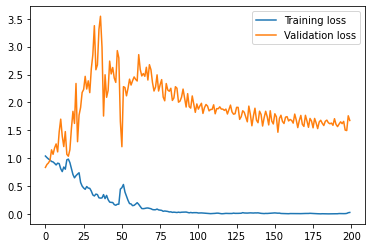

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### Making Predictions: 

In [ ]:
y_pred=model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
y_pred_test_rev = y_scaler.inverse_transform(y_pred)
y_pred_train_rev = y_scaler.inverse_transform(y_pred_train)
y_train_rev = y_scaler.inverse_transform(y_train)
y_test_rev = y_scaler.inverse_transform(y_test)

In [ ]:
import sklearn.metrics as sm
print("Mean absolute error =", 
      round(sm.mean_absolute_error(y_test_rev, y_pred_test_rev), 5)) 
print("Mean squared error =", 
      round(sm.mean_squared_error(y_test_rev, y_pred_test_rev), 5)) 
print("Median absolute error =", 
      round(sm.median_absolute_error(y_test_rev, y_pred_test_rev), 5)) 
print("Explain variance score =", 
      round(sm.explained_variance_score(y_test_rev, y_pred_test_rev), 5)) 
print("R2 score =", 
      round(sm.r2_score(y_test_rev, y_pred_test_rev), 5))

Mean absolute error = 0.06894
Mean squared error = 0.00994
Median absolute error = 0.05114
Explain variance score = -0.24106
R2 score = -0.27902


In [ ]:
trainScore = sm.mean_squared_error(y_train_rev, y_pred_train_rev) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sm.mean_squared_error(y_test_rev, y_pred_test_rev) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.10 RMSE


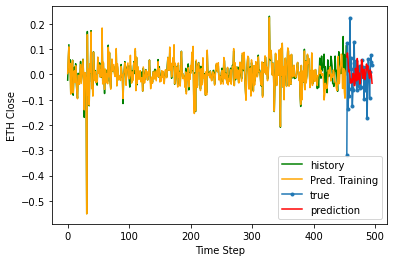

In [ ]:
plt.plot(np.arange(0, len(y_train_rev)), y_train_rev, 'g', label="history")
plt.plot(np.arange(0, len(y_pred_train_rev)), y_pred_train_rev, 'orange', label="Pred. Training")
plt.plot(np.arange(len(y_train_rev), len(y_train_rev) + len(y_test_rev)), y_test_rev, marker='.', label="true")
plt.plot(np.arange(len(y_train_rev), len(y_train_rev) + len(y_test_rev)), y_pred_test_rev, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

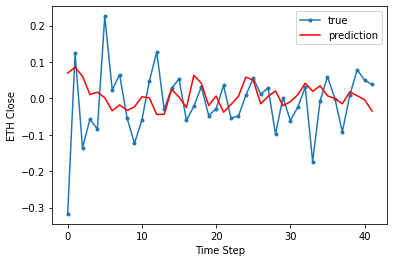

In [ ]:
plt.plot(y_test_rev, marker='.', label="true")
plt.plot(y_pred_test_rev, 'r', label="prediction")
plt.ylabel('ETH Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();